# regex實戰-2: COVID-19疫苗劑量搜尋篇

## 目標
* 在一篇結構不太嚴謹的文本中搜尋出「疫苗名稱」及其「劑量」。
* 搜尋範圍是WHO(世衛組織)的EUA緊急授權疫苗，不在EUA清單內的略過。
* 輸出一個dict，格式為：<font color='yellow' size="+1">{'BNT': '23.5', 'AZ': '110', ...}</font>(dict內劑量數字為假設值)。劑量數字本該用浮點數，但為了清楚看出有無符合後面劑量數字比對規定，故意用字串。

## 文本結構
* 純文字檔。
* 每行記錄一支疫苗。行首有編號，編號後面是疫苗名稱。但疫苗名稱的前後都可能會有些「干擾」文字。
* 有些疫苗有WHO的EUA，有些沒有。請記住：沒有EUA的不是這次搜尋範圍。
* 劑量就隱沒在疫苗名稱後的字串中。
* 劑量的判斷標準是：
    1. 劑量數字之前要有 <font color='tomato' size="+2">va</font>, <font color='tomato' size="+2">b</font>, 或 <font color='tomato' size="+2">a</font> 這3個識別字其中之一，大小寫不拘。
    2. 這3個識別字不能緊黏在其他文字後面，要有區隔(例如空白、標點符號等)。識別字和劑量之間，則有0到n個空白。
    3. 劑量數字可以是整數或浮點數。
    4. 劑量的後面要跟著 <font color='tomato' size="+2">cc</font> 或 <font color='tomato' size="+2">ml</font> 其中之一，其間有0到n個空白。
    5. 同一支疫苗如果有多個數字符合「劑量」標準，只採最前面那個。

## 其他要求
1. regex的pattern只能有2個capturing groups：
    1. group #1: 疫苗名稱
    2. group #2: 劑量數字。只包括數字，不含後面的``cc``或``ml``。
2. 劑量數字比對規定：
    1. 小數點後無數字，如<font color='pink' size="+2">12.</font>，只取整數部分，即<font color='tomato' size="+2">12</font>而非<font color='tomato' size="+2">12.</font>。
    2. 小數點後為零，如<font color='pink' size="+2">12.0</font>，取<font color='tomato' size="+2">12.0</font>而非<font color='tomato' size="+2">12</font>。
    3. 小數點前無數字，如<font color='pink' size="+2">.5</font>，取<font color='tomato' size="+2">.5</font>而非<font color='tomato' size="+2">0.5</font>。
    4. 小數點前為零，如<font color='pink' size="+2">0.5</font>，取<font color='tomato' size="+2">0.5</font>而非<font color='tomato' size="+2">.5</font>。
    5. 單一小數點，如 <font color='pink' size="+2">.</font>，等於<font color='tomato' size="+2">沒有數字</font>而非<font color='tomato' size="+2">0</font>，所以肯定沒有匹配。
3. pattern要運用到regex的下列特性：    
    1. 非貪婪模式(non-greedy mode)
    2. 單字邊界(word boundary)
    3. 非捕獲羣組(non-capturing group)
    4. 命名捕獲羣組(named capturing group)
    5. 環視(look-around)
<!--     6. ```.*?\b(BNT|Moderna|AZ|Johnson|Sinovac|Sinopharm)\b.*?\b(?:va|b|a)\s*(?P<digit>\d*(?<!\.)\.\d+|\d+)\s*(?:cc|ml|\.\s*cc|\.\s*ml)\b``` -->

In [8]:
import re
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(
    f"'re' module imported.\n"
    f'{now}'
)

're' module imported.
2021-09-25 15:18:03


## 本篇使用的一些常數

In [4]:
LEN_SINGLE = 20
LEN_DOUBLE = 30
SINGLE_LINE = '-' * LEN_SINGLE   # '-----'
DOUBLE_LINE = '=' * LEN_DOUBLE   # '====='
LINE_RETURN = '\n'
print('Constants defined.')

Constants defined.


## 匯入原始文本
* 文本既是純文字檔，可用Python的open()函數以唯讀模式開啟。
* read()傳回的是個str，內容就是整個檔案的文字。
* 千萬記得要運用context manager。切勿這樣：<br>
    <font color='tan' size="+1">fs = open('./vaccines.dat', 'r')  # 不懂用context manager</font>    

In [1]:
with open('./vaccines.dat', 'r') as fs:
    test_str = fs.read()
print(test_str)


COVID-19 Vaccines List

1.  German <BNT> Harnessing the power of the immune system BNT,va 536 ml  va 199cc  Develop novel therapies against cancer and infectious diseases b 15ml  vaccines are one of the most cost-effective investments.

2. USA's Moderna, plays a fundamental role in human biology. 99cc transferring the instructions stored in DNA to make the proteins required in every living cell.  v57.c  b23.ml Our approach is to use mRNA to cure disease.

3. UBI: It is an entrepreneurial biopharmaceutical company aavab kk 10.3cc  kkkji b 13.0cc We committed to delivering life-changing solutions to improve global health.  b 9.5cc

4. British az. The Oxford–AstraZeneca COVID-19 vaccine. kva 3.5cc  250 AZ is a viral vector vaccine for prevention of COVID-19. va10.5cc The Oxford-AstraZeneca vaccine could slow the transmission of the virus.

5.Johnson;  The Johnson & Johnson COVID-19 vaccine was launched on February 27, 2021.  545.00cc  av5 ml  It became the third vaccine against coronavir

## 匹配位置圖
![](https://i.imgur.com/EzrA1Tw.png)
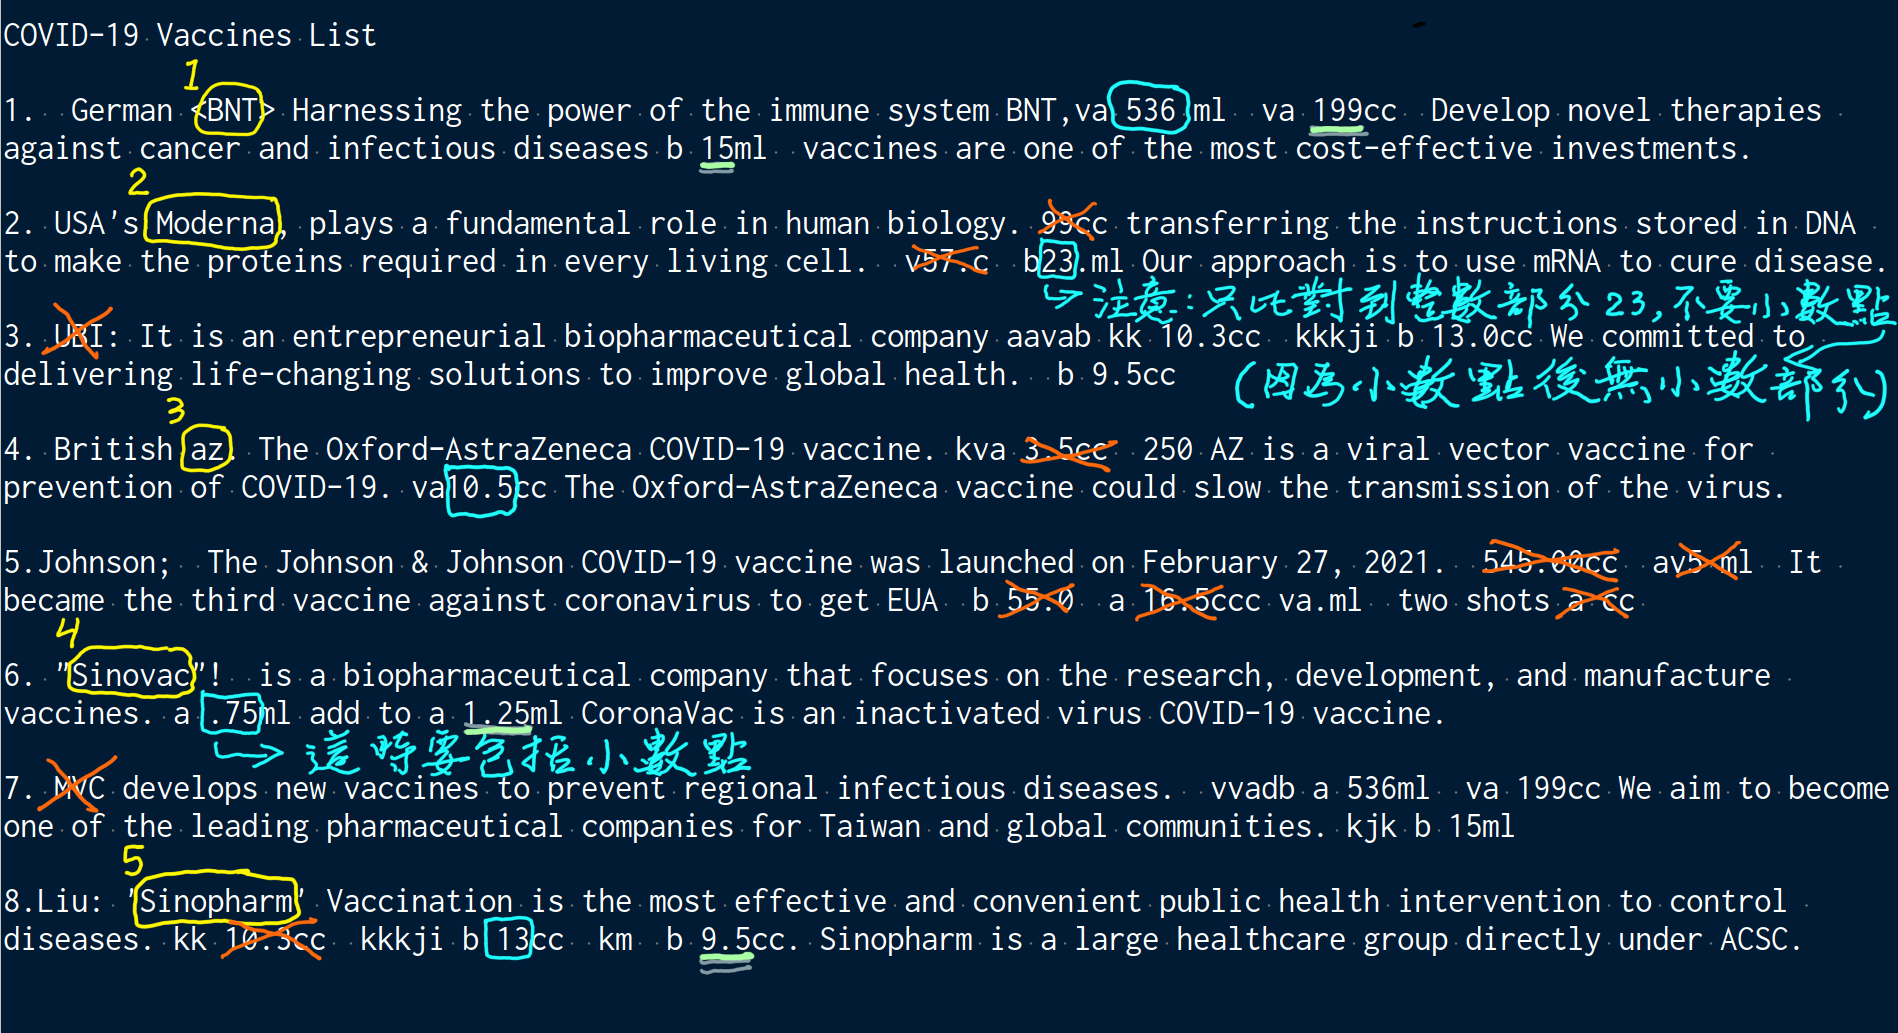


In [14]:
who_eua_vaccines = ('BNT', 'Moderna', 'AZ', 'Johnson',
                    'Sinovac', 'Sinopharm', 'Covishield')
# BNT|Moderna|AZ|Johnson|Sinovac|Sinopharm
pattern_head = rf'.*?\b({"|".join(who_eua_vaccines)})\b'
# pattern_tail = r'.*?\b(?:va|b|a)\s*(\d+(?:\.\d*)?)\s*(?=cc|ml)\b'
# pattern_tail = r'.*?\b(?:va|b|a)\s*(\d+(?:\.\d*)?)\s*(?:cc|ml)\b'
# pattern_tail = r'.*?\b(?:va|b|a)\s*(\d*(?<!\.)\.\d+|\d+)\s*(?:cc|ml|\.\s*cc|\.\s*ml)\b'
pattern_tail = r'.*?\b(?:va|b|a)\s*(?P<num>\d*(?<!\.)\.\d+|\d+)\s*(?:cc|ml|\.\s*cc|\.\s*ml)\b'
# ?P<digit>
#  .*?\b(?:va|b|a)\s*(\d*(?<!\.)\.\d+|\d+)\s*(?:cc|ml|\.\s*cc|\.\s*ml)\b

pattern = f'{pattern_head}{pattern_tail}'
print(f'pattern:\n{pattern}')

pattern:
.*?\b(BNT|Moderna|AZ|Johnson|Sinovac|Sinopharm|Covishield)\b.*?\b(?:va|b|a)\s*(?P<num>\d*(?<!\.)\.\d+|\d+)\s*(?:cc|ml|\.\s*cc|\.\s*ml)\b


## pattern分解圖
<!-- ![](https://i.imgur.com/2uW3J0G.png) -->

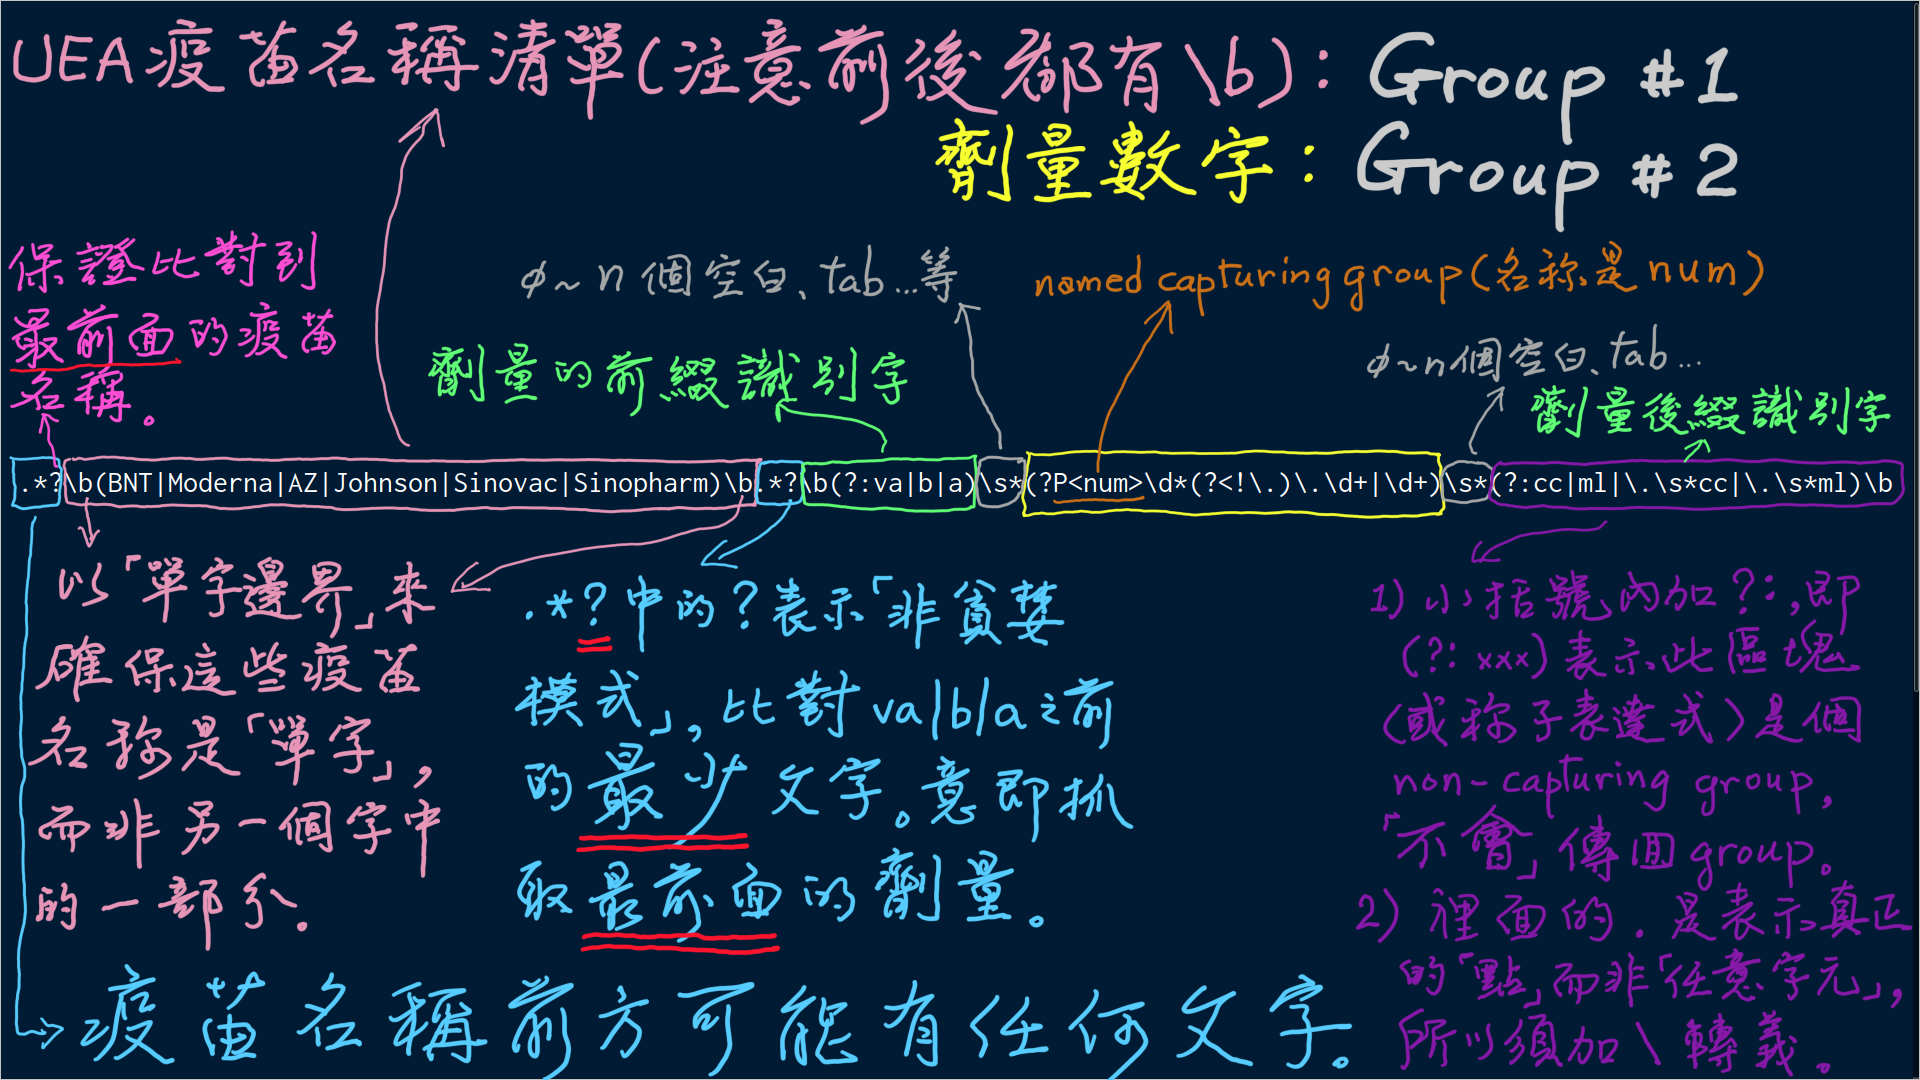

<!-- https://i.imgur.com/2uW3J0G.png -->

In [15]:
vaccine_doses = {}
results = re.findall(pattern=pattern, string=test_str, flags=re.MULTILINE|re.IGNORECASE)
if results:
    for groups in results:
        vaccine_doses[groups[0]] = groups[1]
else:
    print('no match.')

print(vaccine_doses)

{'BNT': '536', 'Moderna': '23', 'az': '10.5', 'Sinovac': '.75', 'Sinopharm': '13'}


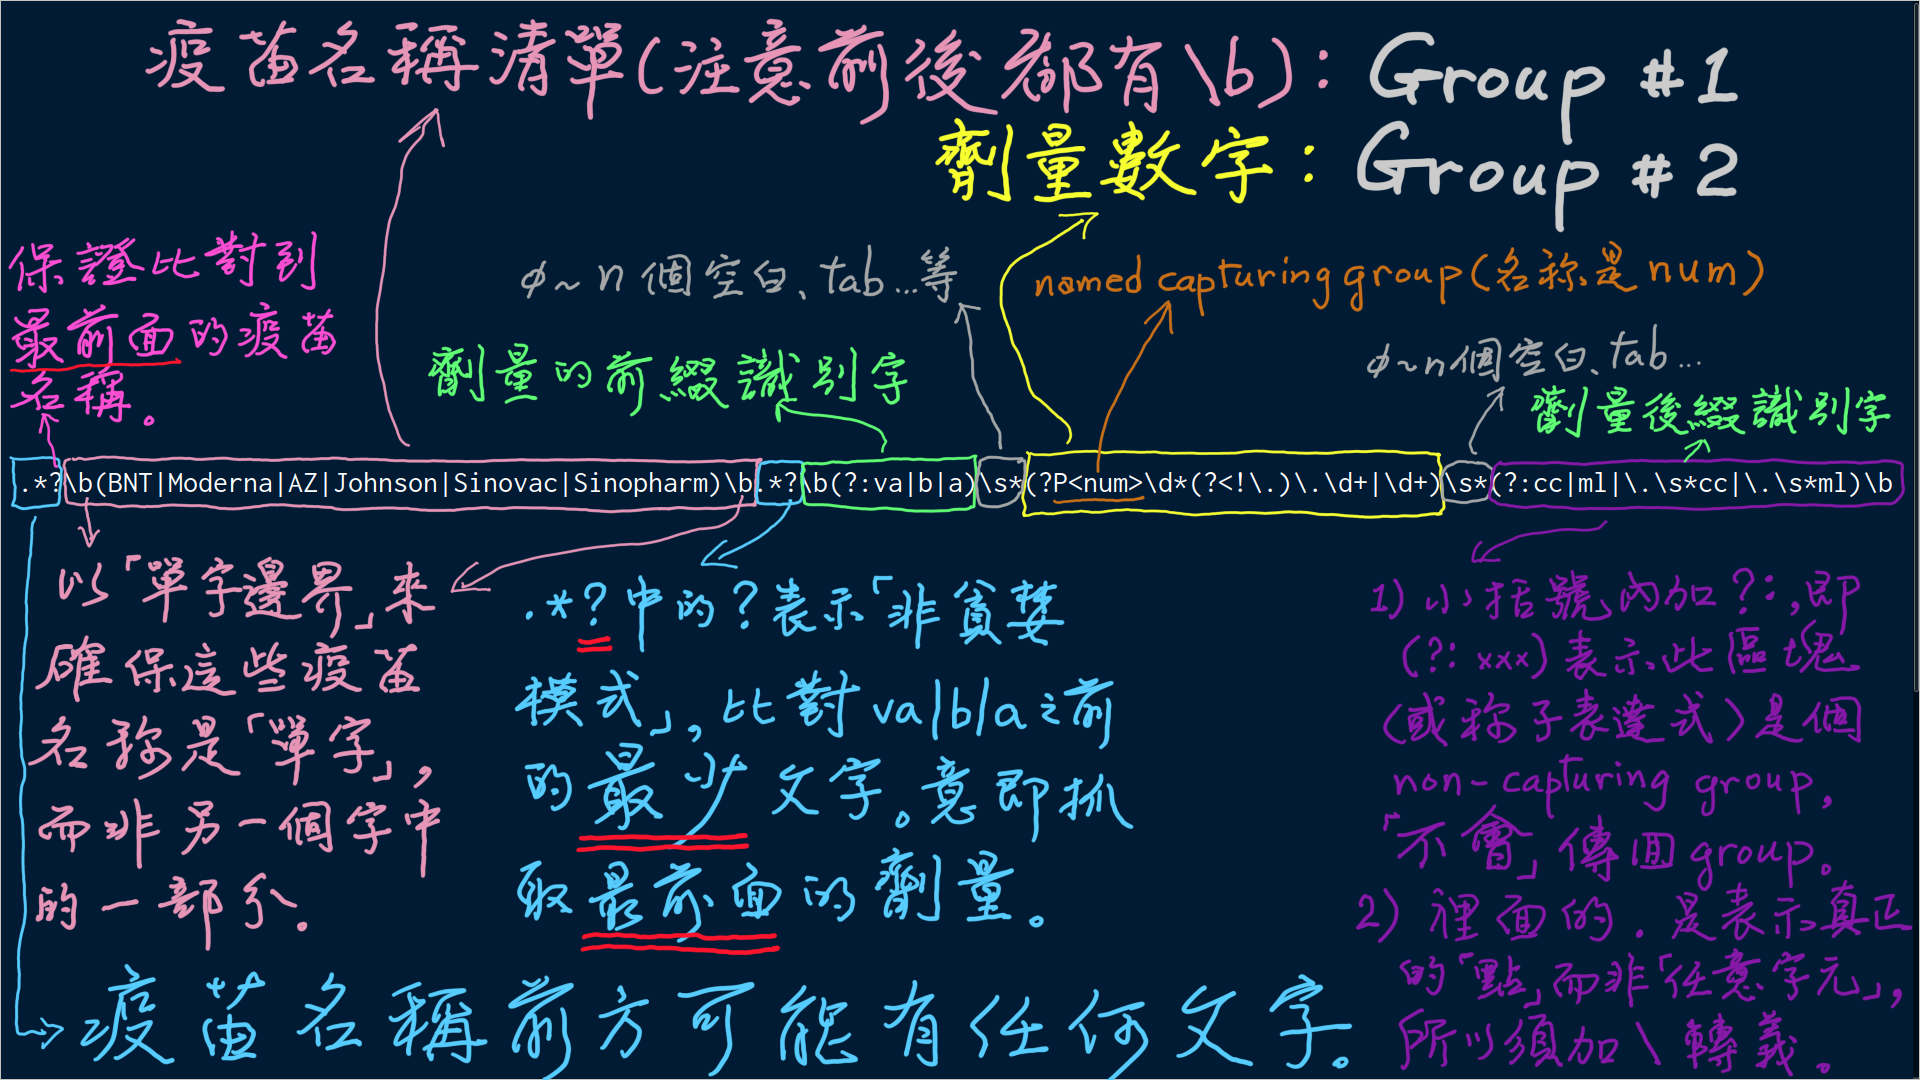
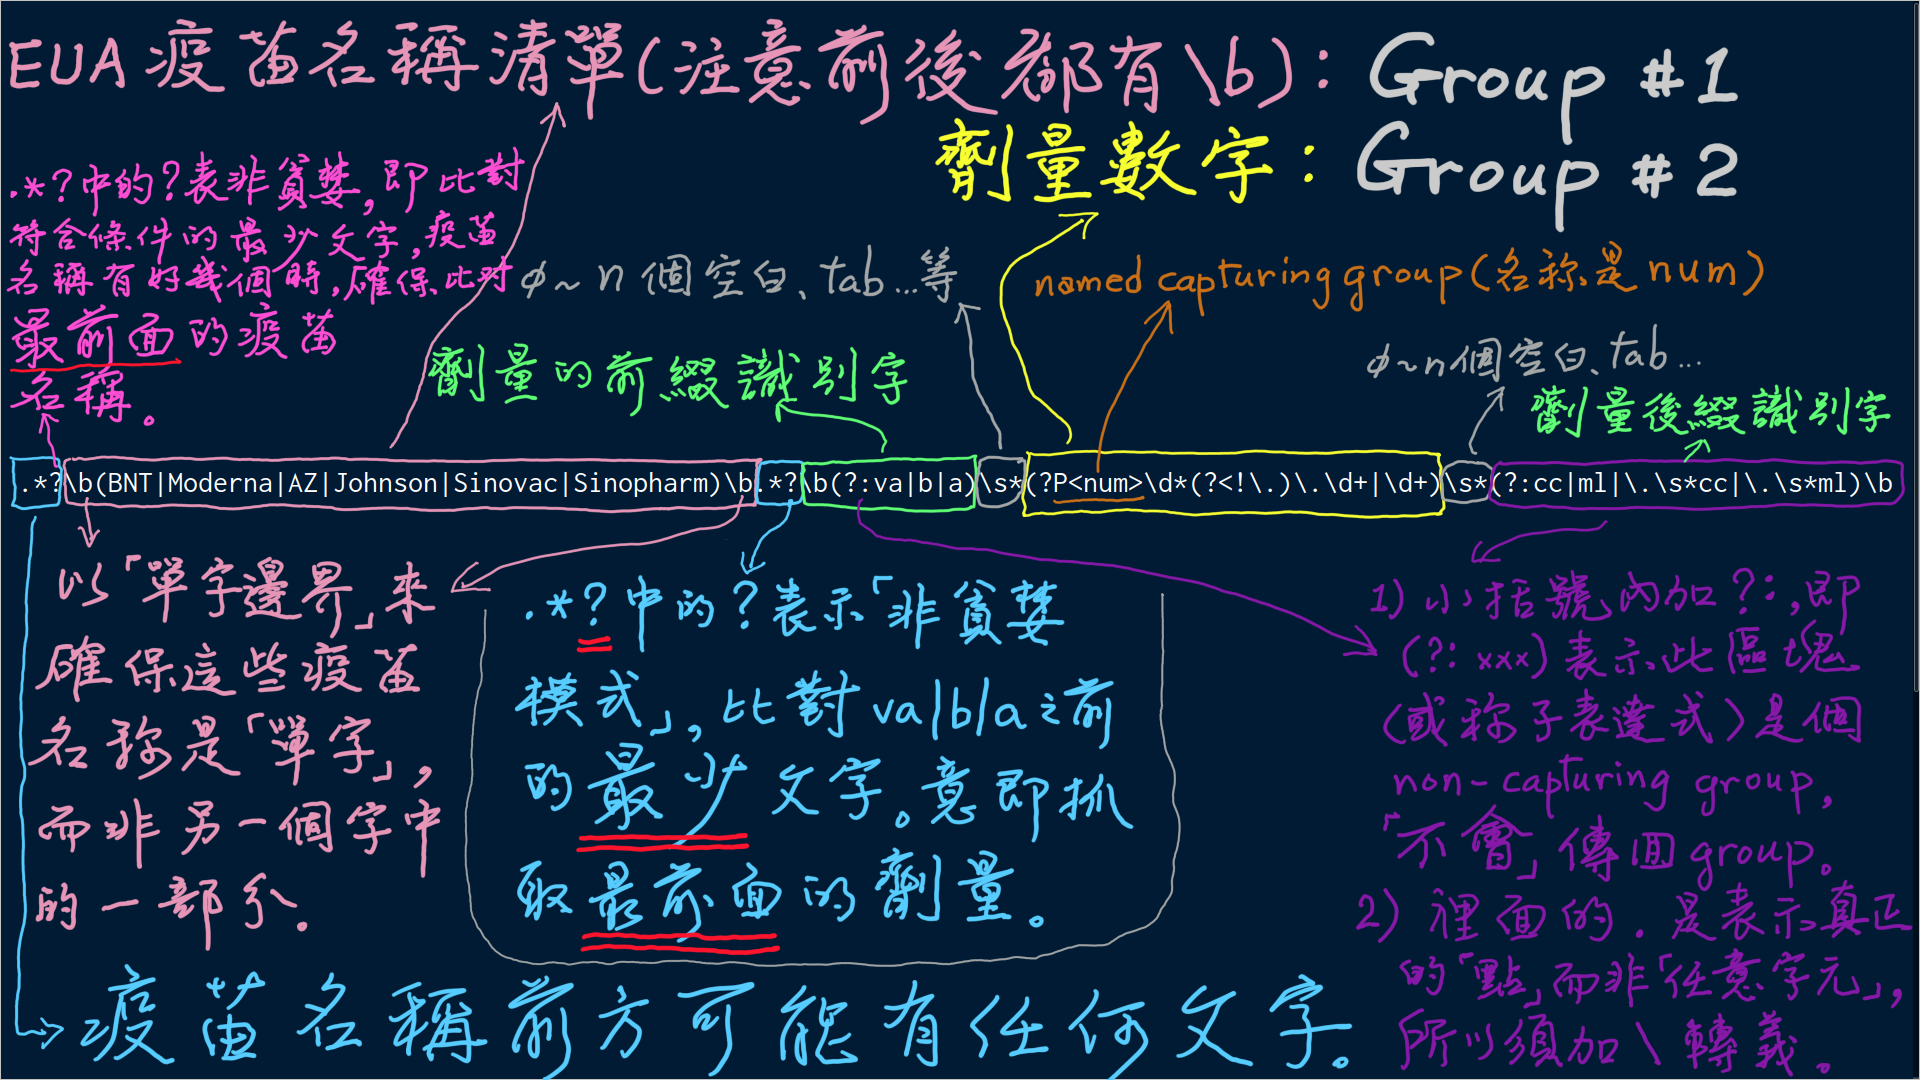